Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [64]:
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

import warnings
warnings.filterwarnings(action = "ignore", message= "^internal gelsd")

### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [65]:
def check_df(df):
    info_df = pd.DataFrame({
        'Tipo': df.dtypes,
        'No Nulos': df.count(),
        'Nulos': df.isnull().sum(),
        '% Nulos': (df.isnull().sum() / len(df)) * 100,
        'Memoria (MB)': df.memory_usage(deep=True).drop('Index') / 1024**2
    })
    return info_df

In [66]:
df = pd.read_csv("./data/drugLibTrain_raw.tsv", sep="\t", index_col = "Unnamed: 0")

display(check_df(df))

,Tipo,No Nulos,Nulos,% Nulos,Memoria (MB)
urlDrugName,object,3107,0,0.000000,0.168724
rating,int64,3107,0,0.000000,0.023705
effectiveness,object,3107,0,0.000000,0.199028
sideEffects,object,3107,0,0.000000,0.198837
condition,object,3106,1,0.032185,0.189918
benefitsReview,object,3089,18,0.579337,0.762602
sideEffectsReview,object,3032,75,2.413904,0.679407
commentsReview,object,3095,12,0.386225,0.958982


In [67]:
display(df.head(10))

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
2372,propecia,1,Ineffective,Severe Side Effects,hair loss,"after taking propecia for over a year, startin...","Low sex drive, before i started taking this dr...",one pill once daily
1043,vyvanse,9,Highly Effective,Mild Side Effects,add,"My mood has noticably improved, I have more en...","a few experiences of nausiea, heavy moodswings...",I had began taking 20mg of Vyvanse for three m...
2715,elavil,10,Considerably Effective,No Side Effects,depression,Although this drug was originally prescribed f...,None.,"One a day, taken about an hour before bedtime."
1591,xanax,10,Highly Effective,No Side Effects,panic disorder,This simply just works fast and without any of...,I really don't have any side effects other tha...,I first started taking this at 3 times per day...
1686,claritin,1,Ineffective,Extremely Severe Side Effects,allergies,none - did nothing to help allergies. i just h...,I had some horrifying mental and physical side...,took one 10 mg pill nightly.


In [68]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
rating,3107.0,7.006115,2.937582,1.0,5.0,8.0,9.0,10.0


### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [69]:
cardinality_df = pd.DataFrame(
    {
        "cardinalidad" : df.nunique(),
        "porc_cardin" : df.nunique() / len(df) * 100
    }
).sort_values("porc_cardin", ascending = False)

display(cardinality_df)


,cardinalidad,porc_cardin
commentsReview,3046,98.036691
benefitsReview,3031,97.553911
sideEffectsReview,2813,90.537496
condition,1426,45.896363
urlDrugName,502,16.157065
rating,10,0.321854
sideEffects,5,0.160927
effectiveness,5,0.160927


En clustering:

- 🔴 Cardinalidad muy alta (>80–90%)

    - Suele indicar identificadores o texto libre

    - ❌ No agrupan bien

- 🟢 Cardinalidad baja / media

    - Ideal para K-Means tras codificación

Por tanto, es correcto y defendible descartar:

In [70]:
df_limpio = df.drop(["urlDrugName", "benefitsReview", "sideEffectsReview", "commentsReview"], axis = 1)

display(df_limpio.head())

,rating,effectiveness,sideEffects,condition
2202,4,Highly Effective,Mild Side Effects,management of congestive heart failure
3117,1,Highly Effective,Severe Side Effects,birth prevention
1146,10,Highly Effective,No Side Effects,menstrual cramps
3947,3,Marginally Effective,Mild Side Effects,acid reflux
1951,2,Marginally Effective,Severe Side Effects,fibromyalgia


Se descartan las variables con una cardinalidad extremadamente alta (reviews y url), ya que representan texto libre o identificadores únicos que no aportan capacidad de agrupamiento al modelo K-Means. Se mantienen aquellas variables con cardinalidad baja o media, más adecuadas para técnicas de clustering.

### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

--- 

Debida a su alta cardinalidad en comparación con las otras columnas, "condition" quedaría descartada como feature para clustering. Además, no es ordinal, One-Hot Encoding generaría decenas o cientos de columnas, introduciría ruido, dimensionalidad innecesaria y distorsión de distancias en K-Means.

Por lo tanto, las features finales serían rating (numérica), effectiveness (cardinal ordinal) y sideEffects (categóirica ordinal)

In [71]:
X = df_limpio[[
    "rating",
    "effectiveness",
    "sideEffects"
]]


### Ejercicio 4 

Transforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [72]:
# Aquí NO se debe usar One-Hot Encoding.

# ¿Por qué?
# - Las categorías tienen orden semántico
# - K-Means trabaja con distancias
# - One-Hot rompe ese orden

# Orden lógico de las categorías

effectiveness_map = {
    "Ineffective": 0,
    "Marginally Effective": 1,
    'Moderately Effective' : 2,
    "Considerably Effective": 3,
    "Highly Effective": 4
}

side_effects_map = {
    "No Side Effects": 0,
    "Mild Side Effects": 1,
    "Moderate Side Effects": 2,
    "Severe Side Effects": 3,
    "Extremely Severe Side Effects": 4
}


In [73]:
X_encoded = X.copy()

X_encoded["effectiveness"] = X_encoded["effectiveness"].map(effectiveness_map)
X_encoded["sideEffects"] = X_encoded["sideEffects"].map(side_effects_map)

# En este punto todas las columnas son numéricas, pero no escaladas.

In [74]:
# Escalado de las features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


### Ejercicio 5: Obtención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

In [75]:
#Transformamos X_scaled en un DataFrame
X_scaled = pd.DataFrame(
    X_scaled,
    columns=X_encoded.columns,
    index=X_encoded.index
)


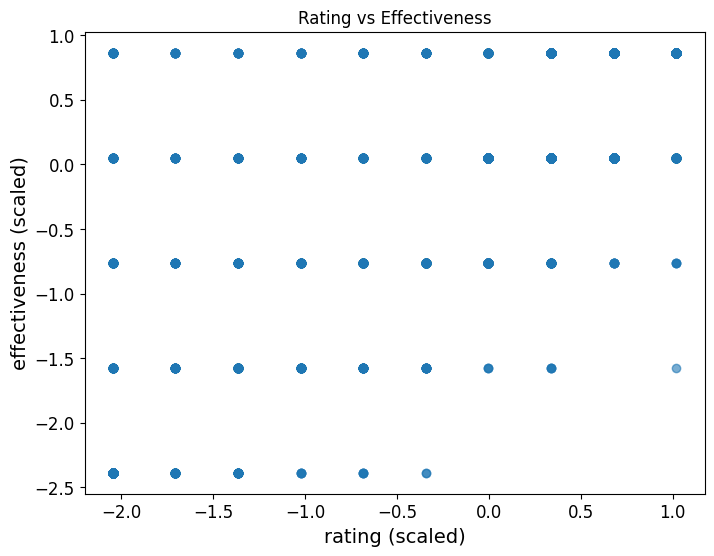

In [76]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled["rating"], X_scaled["effectiveness"], alpha=0.6)
plt.xlabel("rating (scaled)")
plt.ylabel("effectiveness (scaled)")
plt.title("Rating vs Effectiveness")
plt.show()


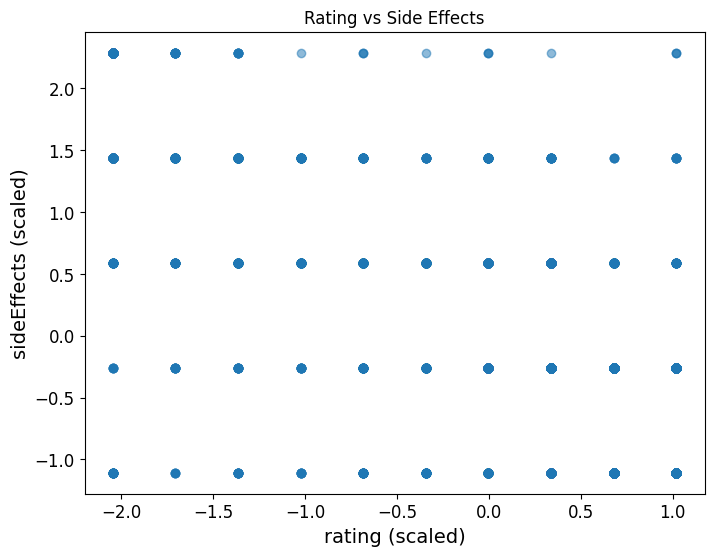

In [77]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled["rating"], X_scaled["sideEffects"], alpha=0.5)
plt.xlabel("rating (scaled)")
plt.ylabel("sideEffects (scaled)")
plt.title("Rating vs Side Effects")
plt.show()


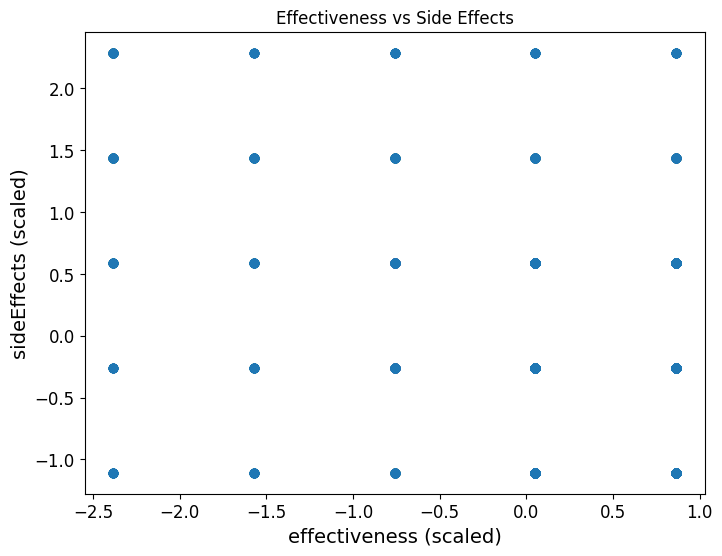

In [78]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled["effectiveness"], X_scaled["sideEffects"], alpha=0.5)
plt.xlabel("effectiveness (scaled)")
plt.ylabel("sideEffects (scaled)")
plt.title("Effectiveness vs Side Effects")
plt.show()


A partir de los scatter plots no se observa una separación claramente definida entre clústeres, aunque se intuyen entre 2 y 4 posibles agrupaciones, especialmente en la relación entre rating y efectos secundarios. Esto sugiere probar valores de K en ese rango en los siguientes ejercicios.

### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

---

- K-Means minimiza la suma de distancias internas; por eso:

   - K pequeño → inercia alta

   - K grande → inercia baja

   - Buscamos el punto de inflexión

Rango razonable: K = 1 a 10
(En datasets pequeños, más no suele aportar nada)

In [79]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


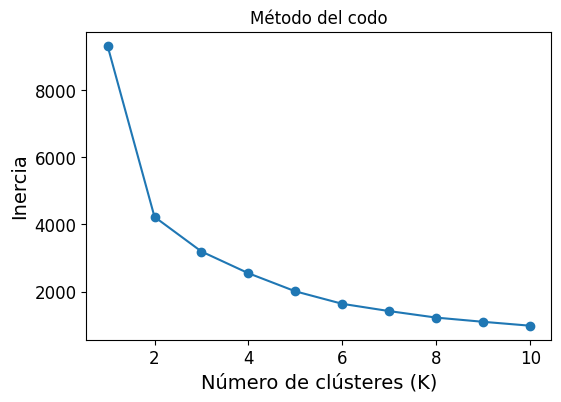

In [80]:
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Número de clústeres (K)")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.show()


El método del codo sugiere un número de clústeres comprendido entre 3 y 4, ya que a partir de ese punto la reducción de la inercia es mucho menos significativa.

### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

--- 

Qué mide el Silhouette Score

Para cada punto:

    - Cómo de cerca está de su propio clúster

    - Cómo de lejos está del clúster más cercano

Valores:

   - ≈ 1 → muy bien agrupado

   - ≈ 0 → en frontera

   - < 0 → mal asignado

Cuanto más alto, mejor.

In [81]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []

K_range = range(2, 7)  # empieza en 2, silhouette no tiene sentido para K=1

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)


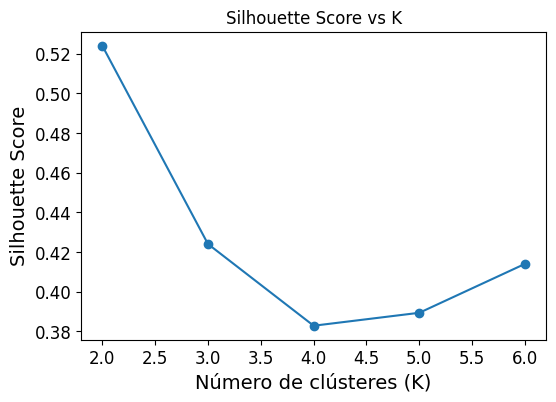

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel("Número de clústeres (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.show()


El silhouette score alcanza su valor máximo para K = 3, lo que indica una mejor separación entre clústeres. Por tanto, se selecciona este valor como número óptimo de clústeres.

### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

In [83]:
kmeans_final = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

labels = kmeans_final.fit_predict(X_scaled)


In [84]:
X_clustered = X_scaled.copy()
X_clustered["cluster"] = labels


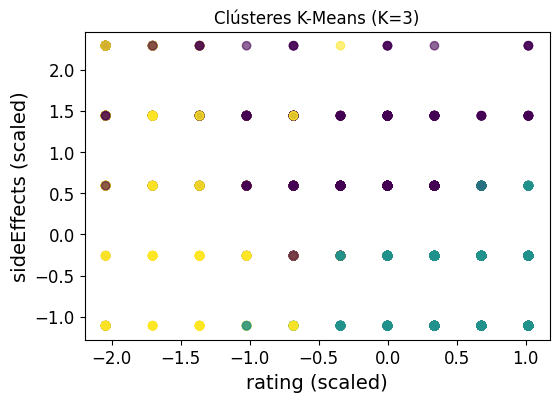

In [93]:
plt.figure(figsize=(6, 4))
plt.scatter(
    X_clustered["rating"],
    X_clustered["sideEffects"],
    c=X_clustered["cluster"],
    alpha=0.6
)
plt.xlabel("rating (scaled)")
plt.ylabel("sideEffects (scaled)")
plt.title("Clústeres K-Means (K=3)")
plt.show()


Se observan clústeres diferenciados principalmente por la relación entre valoración y efectos secundarios, identificándose un grupo con alta valoración y bajos efectos adversos, otro con valoraciones medias y un tercero con bajas valoraciones y mayor presencia de efectos secundarios.

### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

In [94]:
centroids = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=X_scaled.columns
)

centroids


,rating,effectiveness,sideEffects
0,-0.442954,0.122627,0.879955
1,0.632995,0.453195,-0.626618
2,-1.644871,-1.844724,0.958643


### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.